In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision.models import MobileNet_V3_Large_Weights
from PIL import Image

In [3]:
# 🚀 CONFIGURATION
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 42     # Smaller batch size for better gradient estimates
EPOCHS = 200        # More epochs with early stopping
LEARNING_RATE = 1e-4  # Lower learning rate for more stable training
PATIENCE = 25       # Increased patience for better convergence
WEIGHT_DECAY = 1e-5  # Reduced weight decay to allow more flexibility
DROPOUT_RATE = 0.3  # Adjusted dropout rate
EXPERIMENT_LOG = "experiment_log.csv"
MODEL_WEIGHTS_PATH = "mobilenetv3_best_weights7.pth"

In [4]:
# 📊 ADVANCED DATA AUGMENTATION
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2)),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset loading with better transforms
train_dataset = datasets.ImageFolder(r"C:\Users\Asus TUF -PC\LeafSense AI training\LeafSenseProcessed\train", transform=train_transform)
val_dataset = datasets.ImageFolder(r"C:\Users\Asus TUF -PC\LeafSense AI training\LeafSenseProcessed\val", transform=val_transform)

# Implement class balancing with weighted sampling
class_counts = [0] * len(train_dataset.classes)
for _, class_idx in train_dataset.samples:
    class_counts[class_idx] += 1

# Calculate weights for each sample based on class frequency
weights = [1.0 / class_counts[class_idx] for _, class_idx in train_dataset.samples]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Use the weighted sampler for the training loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [5]:
# 🔥 ENHANCED EVALUATION FUNCTION
def evaluate_model(model, val_loader, criterion):
    """Evaluate the model during validation with more metrics."""
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    val_loss /= len(val_loader)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Multi-class AUC calculation
    num_classes = len(val_dataset.classes)
    if num_classes > 2:
        try:
            val_auc = roc_auc_score(np.eye(num_classes)[all_labels], all_probs, multi_class='ovr')
        except ValueError:
            val_auc = 0.0
    else:
        try:
            val_auc = roc_auc_score(all_labels, [prob[1] for prob in all_probs])
        except ValueError:
            val_auc = 0.0

    # More detailed analysis once training is complete
    if accuracy > 0.85:  # Only print detailed analysis when accuracy is good
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))
        
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{accuracy:.4f}.png')

    return val_loss, val_auc, accuracy


In [6]:
# 🛠️ IMPROVED MODEL ARCHITECTURE
class LeafClassifier(nn.Module):
    def __init__(self, num_classes, DROPOUT_RATE=0.25):
        super(LeafClassifier, self).__init__()
        # Use the latest weights for better initialization
        self.model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        
        # Freeze fewer layers - only freeze the first 50% of layers
        # This allows for better fine-tuning to your specific leaf dataset
        total_params = len(list(self.model.parameters()))
        for param in list(self.model.parameters())[:total_params//2]:
            param.requires_grad = False
            
        # Replace with a simpler, more robust classifier
        in_features = self.model.classifier[0].in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),  # Add batch normalization for stability
            nn.ReLU(inplace=True),
            nn.Dropout(DROPOUT_RATE),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(DROPOUT_RATE),
            
            nn.Linear(256, num_classes)
        )
        
        # Apply better weight initialization
        self._initialize_weights()

    def forward(self, x):
        return self.model(x)
    
    def _initialize_weights(self):
        """Apply improved weight initialization to newly added layers"""
        for m in self.model.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * CE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        else:
            return F_loss

# Initialize the model
num_classes = len(train_dataset.classes)
model = LeafClassifier(len(train_dataset.classes), DROPOUT_RATE = 0.25).to(DEVICE)


In [7]:
# 🔥 ENHANCED LOSS FUNCTION & OPTIMIZER

torch.cuda.empty_cache()

# Use label smoothing to improve generalization
criterion = FocalLoss(gamma=2)


# ✅ Simplified optimizer to reduce memory overhead
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


# Better scheduler with warm restarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=LEARNING_RATE/100)

# ✅ Enable Mixed Precision Training (AMP) to reduce memory usage
scaler = torch.cuda.amp.GradScaler()

# ✅ Reduce batch size dynamically to prevent OOM errors
try:
    BATCH_SIZE = max(8, BATCH_SIZE // 2)  # Halve the batch size
except NameError:
    BATCH_SIZE = 8  # Use a small batch size by default if undefined

print(f"✅ Using batch size: {BATCH_SIZE}")


✅ Using batch size: 21


C:\Users\Asus TUF -PC\AppData\Local\Temp\ipykernel_15200\36745493.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [8]:
# 🛑 IMPROVED EARLY STOPPING CLASS
class EarlyStopping:
    def __init__(self, patience=PATIENCE, verbose=True, delta=0.001, path=MODEL_WEIGHTS_PATH):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta  # Minimum change to count as improvement
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.best_accuracy = 0.0  # Track best accuracy
        self.path = path

    def __call__(self, val_loss, val_acc, model):
        # Use both accuracy and validation loss for monitoring
        score = val_acc - val_loss * 0.2  # Balance between accuracy and loss
        
        if self.best_score is None:
            self.best_score = score
            self.best_accuracy = val_acc  # Initialize best accuracy
            self.save_checkpoint(val_loss, val_acc, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"⚠️ Early stopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            if val_acc > self.best_accuracy:  # Update best accuracy if current is better
                self.best_accuracy = val_acc
            self.save_checkpoint(val_loss, val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, val_acc, model):
        """Save model when validation performance improves."""
        if self.verbose:
            print(f"✅ Validation score improved ({self.val_loss_min:.4f} → {val_loss:.4f} | Acc: {val_acc:.4f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [9]:
# 🔄 MIXUP DATA AUGMENTATION
def mixup_data(x, y, alpha=0.2):
    """Performs mixup augmentation which helps with regularization and generalization."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(DEVICE)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Criterion for mixup training."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [10]:
# 🚀 ENHANCED TRAINING FUNCTION
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, epochs=EPOCHS):
    history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'accuracy': []}
    best_accuracy = 0.0

    for epoch in range(epochs):
        start_time = time.time()

        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            # Apply mixup augmentation 50% of the time
            if np.random.random() > 0.5:
                images, labels_a, labels_b, lam = mixup_data(images, labels)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                # Regular training
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Training steps
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            running_loss += loss.item()

        # --- VALIDATION PHASE ---
        val_loss, val_auc, val_acc = evaluate_model(model, val_loader, criterion)
        
        # Learning rate scheduling
        scheduler.step()
        
        # Logging
        history['train_loss'].append(running_loss / len(train_loader))
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        history['accuracy'].append(val_acc)

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            
            # Save the best model specifically for best accuracy
            torch.save(model.state_dict(), "mobilenetv3_best_accuracy7.pth")
            print(f"🏆 New best accuracy: {best_accuracy:.4f} - Saved best accuracy model")


        # Early stopping check
        early_stopping(val_loss, val_acc, model)

        # Display training results
        duration = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch [{epoch+1}/{epochs}], Time: {duration:.2f}s, LR: {current_lr:.6f}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss:.4f}, AUC: {val_auc:.4f}, Accuracy: {val_acc:.4f}, Best: {best_accuracy:.4f}")

        # Save training logs to CSV
        with open(EXPERIMENT_LOG, 'a') as f:
            if epoch == 0 and not os.path.getsize(EXPERIMENT_LOG):
                f.write("epoch,train_loss,val_loss,val_auc,accuracy,lr\n")
            f.write(f"{epoch+1},{running_loss/len(train_loader):.6f},{val_loss:.6f},{val_auc:.6f},{val_acc:.6f},{current_lr:.8f}\n")

        if early_stopping.early_stop:
            print(f"🔥 Early stopping triggered at epoch {epoch+1}. Best accuracy: {best_accuracy:.4f}")
            break

    return history, best_accuracy


In [11]:
# 🔥 ENHANCED EVALUATION FUNCTION
def evaluate_model(model, val_loader, criterion):
    """Evaluate the model during validation with more metrics."""
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    val_loss /= len(val_loader)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Multi-class AUC calculation
    num_classes = len(val_dataset.classes)
    if num_classes > 2:
        try:
            val_auc = roc_auc_score(np.eye(num_classes)[all_labels], all_probs, multi_class='ovr')
        except ValueError:
            val_auc = 0.0
    else:
        try:
            val_auc = roc_auc_score(all_labels, [prob[1] for prob in all_probs])
        except ValueError:
            val_auc = 0.0

    # More detailed analysis once training is complete
    if accuracy > 0.85:  # Only print detailed analysis when accuracy is good
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))
        
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{accuracy:.4f}.png')

    return val_loss, val_auc, accuracy


In [12]:
# 📊 IMPROVED PLOTTING FUNCTION
def plot_results(history, best_accuracy):
    """Plot the training and validation results with more details."""
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.plot(history['accuracy'], label=f'Accuracy (Best: {best_accuracy:.4f})')
    plt.axhline(y=0.89, color='r', linestyle='--', label='Target Accuracy (89%)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.plot(history['val_auc'], label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC Score')
    plt.title('Validation AUC')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Display final metrics and configuration
    plt.subplot(2, 2, 4)
    plt.axis('off')
    info_text = (
        f"Model: MobileNetV3-Large\n"
        f"Final Accuracy: {history['accuracy'][-1]:.4f}\n"
        f"Best Accuracy: {best_accuracy:.4f}\n"
        f"Final AUC: {history['val_auc'][-1]:.4f}\n"
        f"Final Val Loss: {history['val_loss'][-1]:.4f}\n"
        f"Batch Size: {BATCH_SIZE}\n"
        f"Learning Rate: {LEARNING_RATE}\n"
        f"Dropout Rate: {DROPOUT_RATE}\n"
        f"Weight Decay: {WEIGHT_DECAY}\n"
        f"Total Epochs: {len(history['accuracy'])}"
    )
    plt.text(0.1, 0.5, info_text, fontsize=12, va='center')
    plt.title('Training Summary', fontsize=14)

    plt.tight_layout()
    plt.savefig('training_results.png', dpi=200)
    plt.show()


In [13]:
# 🔍 MODEL EVALUATION AFTER TRAINING
def evaluate_best_model(model_path, test_loader):
    """Evaluate the best model on the test set."""
    best_model = LeafClassifier(len(train_dataset.classes)).to(DEVICE)
    best_model.load_state_dict(torch.load(model_path))
    best_model.eval()
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = best_model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n🏆 Final Model Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))
    
    return accuracy


# 🔍 NEW FUNCTION TO TEST MODEL WITH SINGLE IMAGE
def test_image(image_path, model_path=None):
    """
    Test a single image with the trained model.
    
    Args:
        image_path (str): Path to the image file
        model_path (str, optional): Path to model weights. Defaults to "mobilenetv3_best_accuracy.pth"
    
    Returns:
        tuple: (predicted_class, confidence)
    """
    if model_path is None:
        # Use the best accuracy model by default
        model_path = "mobilenetv3_best_accuracy7.pth"
    
    # Load the model
    model = LeafClassifier(len(train_dataset.classes)).to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Set up image transformation
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Load and transform the image
    try:
        image = Image.open(image_path).convert('RGB')
        input_tensor = test_transform(image).unsqueeze(0).to(DEVICE)
        
        # Make prediction
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted_class = torch.max(probabilities, 1)
            
        # Get class names
        class_names = train_dataset.classes
        predicted_label = class_names[predicted_class.item()]
        confidence_value = confidence.item() * 100
        
        # Display results
        print(f"\n🍃 Prediction Results for {os.path.basename(image_path)}")
        print(f"Predicted Class: {predicted_label}")
        print(f"Confidence: {confidence_value:.2f}%")
        
        # Display top-3 predictions
        print("\nTop-3 Predictions:")
        probs, indices = torch.topk(probabilities, 3)
        for i in range(3):
            print(f"{class_names[indices[0][i]]}: {probs[0][i].item()*100:.2f}%")
        
        # Visualize the image with prediction
        plt.figure(figsize=(8, 8))
        plt.imshow(np.array(image))
        plt.title(f"Prediction: {predicted_label} ({confidence_value:.2f}%)")
        plt.axis('off')
        plt.show()
        
        return predicted_label, confidence_value
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, 0


# Create experiment log file
if not os.path.exists(EXPERIMENT_LOG):
    with open(EXPERIMENT_LOG, 'w') as f:
        f.write("epoch,train_loss,val_loss,val_auc,accuracy,lr\n")


🌿 Starting leaf classification training on cuda
📚 Training set: 32564 images, Validation set: 19873 images
🏷️ Classes: ['ArtocarpusHeterophyllus', 'BroussonetiaPapyrifera', 'CeibaPentandra', 'CocosNucifera', 'DurioZibethinus', 'ElaeisGuineensis', 'EuphorbiaPulcherrima', 'ManihotEsculenta', 'SamaneaSaman', 'TheobromaCacao']
🏆 New best accuracy: 0.6305 - Saved best accuracy model
✅ Validation score improved (inf → 1.1846 | Acc: 0.6305). Saving model...
Epoch [1/200], Time: 237.65s, LR: 0.000091, Train Loss: 2.6774, Val Loss: 1.1846, AUC: 0.9038, Accuracy: 0.6305, Best: 0.6305
🏆 New best accuracy: 0.7035 - Saved best accuracy model
✅ Validation score improved (1.1846 → 0.7304 | Acc: 0.7035). Saving model...
Epoch [2/200], Time: 204.92s, LR: 0.000066, Train Loss: 1.0219, Val Loss: 0.7304, AUC: 0.9416, Accuracy: 0.7035, Best: 0.7035
🏆 New best accuracy: 0.7431 - Saved best accuracy model
✅ Validation score improved (0.7304 → 0.7301 | Acc: 0.7431). Saving model...
Epoch [3/200], Time: 203.82

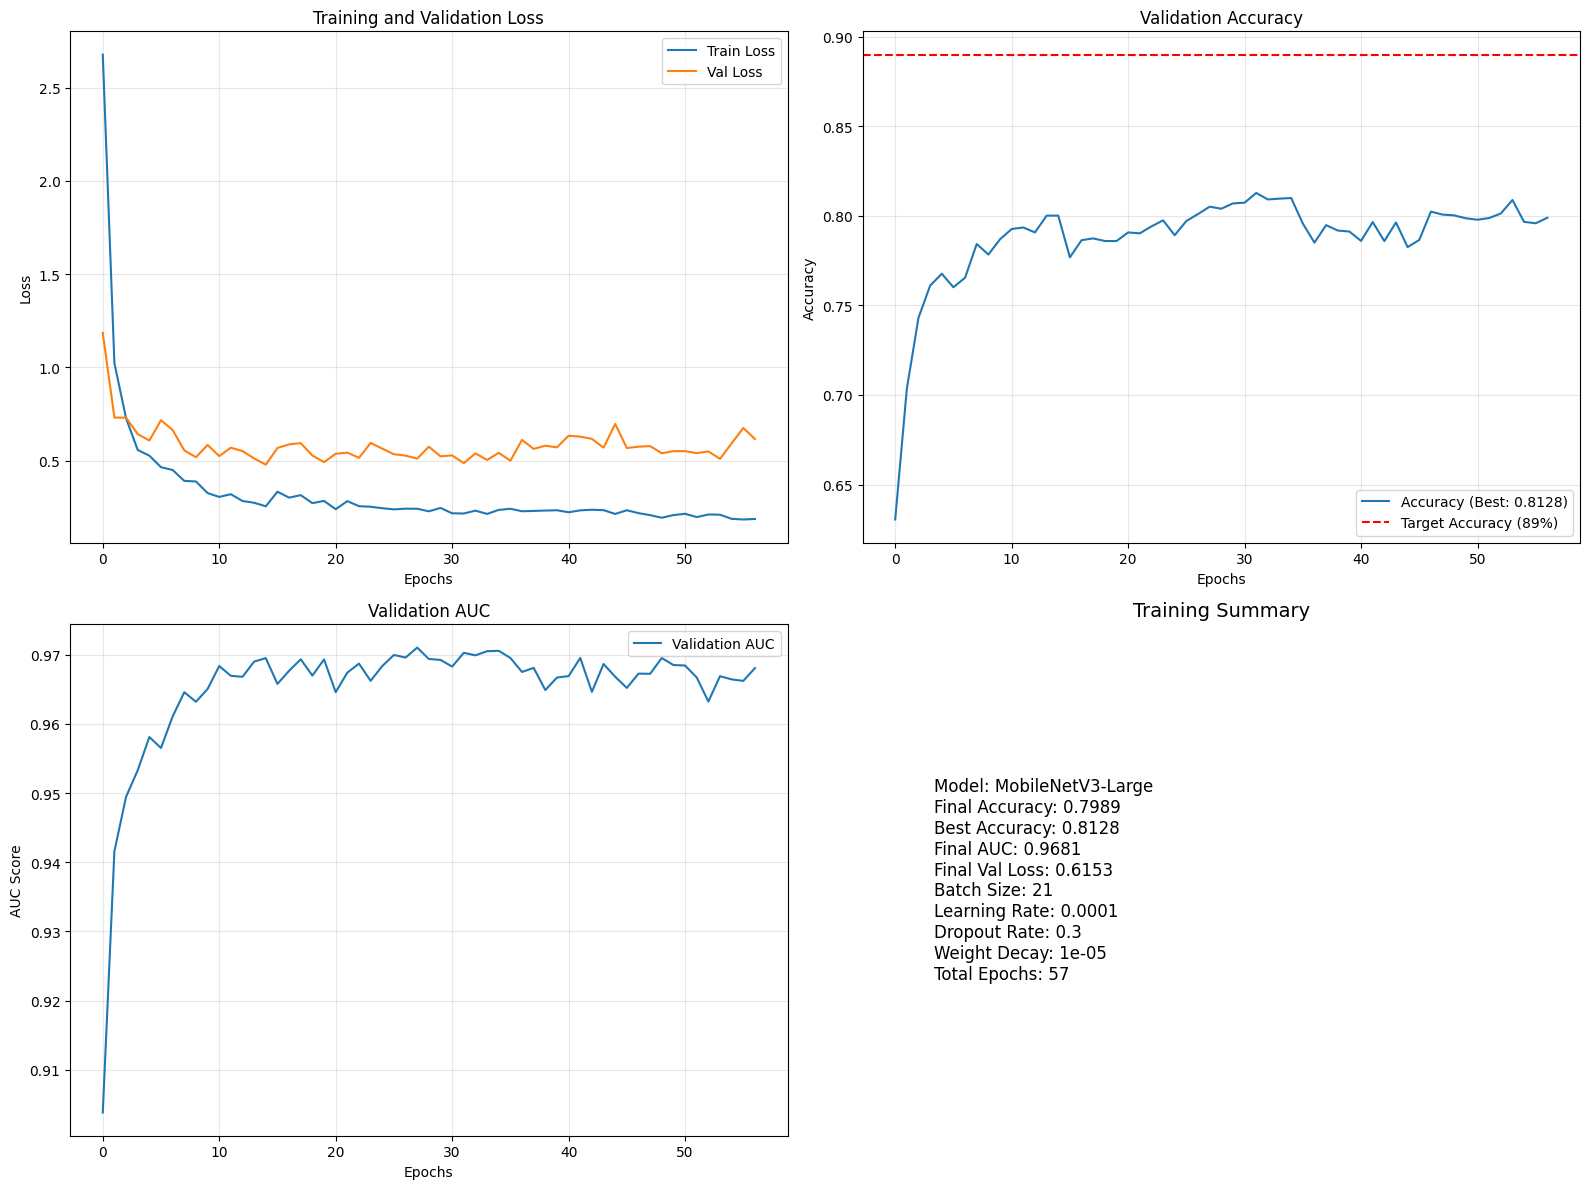

C:\Users\Asus TUF -PC\AppData\Local\Temp\ipykernel_15200\1846949019.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path))



🏆 Final Model Accuracy: 0.8128

Classification Report:
                         precision    recall  f1-score   support

ArtocarpusHeterophyllus       0.78      0.79      0.79      2086
 BroussonetiaPapyrifera       0.71      0.83      0.76      2093
         CeibaPentandra       0.76      0.77      0.76      2086
          CocosNucifera       0.87      0.95      0.91      2100
        DurioZibethinus       0.74      0.78      0.76      2100
       ElaeisGuineensis       0.89      0.83      0.86      2037
   EuphorbiaPulcherrima       0.94      0.71      0.81      2100
       ManihotEsculenta       0.77      0.94      0.85      1071
           SamaneaSaman       0.89      0.76      0.82      2100
         TheobromaCacao       0.83      0.83      0.83      2100

               accuracy                           0.81     19873
              macro avg       0.82      0.82      0.81     19873
           weighted avg       0.82      0.81      0.81     19873


✅ Training completed. Best acc

In [14]:
# 🚀 RUN TRAINING
print(f"🌿 Starting leaf classification training on {DEVICE}")
print(f"📚 Training set: {len(train_dataset)} images, Validation set: {len(val_dataset)} images")
print(f"🏷️ Classes: {train_dataset.classes}")

# Initialize early stopping with improved monitoring
early_stopping = EarlyStopping(patience=PATIENCE, path=MODEL_WEIGHTS_PATH)

# Run training
history, best_accuracy = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    early_stopping, 
    epochs=EPOCHS
)

# Plot the results
plot_results(history, best_accuracy)

# Evaluate the final best model
final_accuracy = evaluate_best_model(MODEL_WEIGHTS_PATH, val_loader)

# Report final results
print(f"\n✅ Training completed. Best accuracy: {best_accuracy:.4f}")
if best_accuracy >= 0.89:
    print(f"🎉 Target accuracy of 89% achieved!")
else:
    print(f"⚠️ Target accuracy not reached. Consider trying different hyperparameters or model architectures.")

C:\Users\Asus TUF -PC\AppData\Local\Temp\ipykernel_15200\1846949019.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



🍃 Prediction Results for 15.png
Predicted Class: TheobromaCacao
Confidence: 78.02%

Top-3 Predictions:
TheobromaCacao: 78.02%
ElaeisGuineensis: 7.94%
ManihotEsculenta: 5.10%


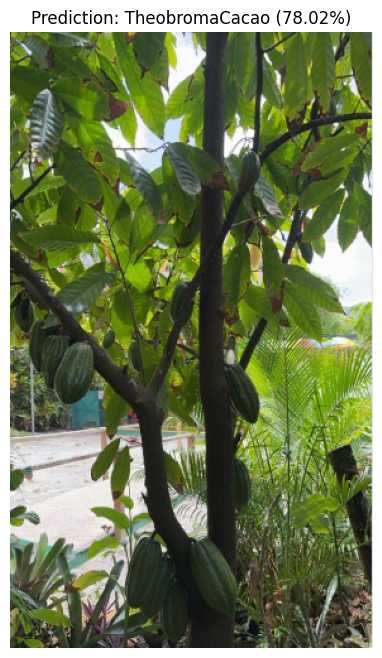

('TheobromaCacao', 78.01641821861267)

In [35]:
# Example usage:
test_image(r"LeafSense/data/test/TheobromaCacao/15.png")